In [1]:
import numpy as np
import pandas as pd

from collections import defaultdict
from tqdm import tqdm

import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, auc

## Задание 1

Собрать более-менее приличную рекомендательную систему с помощью GBDT. Использование трюков из лекции (и не из неё), тюнинг и разумных объемов фича инжиниринг прям нужен. 

In [2]:
train = pd.read_csv("data/train.csv")

In [3]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [4]:
songs = pd.read_csv('data/songs.csv')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [5]:
members = pd.read_csv('data/members.csv')
members = members.rename(columns={'bd': "age"})
members.head()

,msno,city,age,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [6]:
print(sorted(members.age.unique()))

[-43, -38, 0, 2, 3, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 72, 73, 74, 76, 78, 82, 83, 85, 87, 89, 90, 93, 95, 96, 97, 101, 102, 103, 105, 106, 107, 111, 112, 131, 144, 931, 1030, 1051]


In [7]:
members.loc[(members.age <= 0) | (members.age > 118), 'age'] = 0

In [8]:
print(sorted(members.age.unique()))

[0, 2, 3, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 72, 73, 74, 76, 78, 82, 83, 85, 87, 89, 90, 93, 95, 96, 97, 101, 102, 103, 105, 106, 107, 111, 112]


In [9]:
train = train.merge(members, on='msno', how='left')
train = train.merge(songs, on='song_id', how='left')

In [10]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,age,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0


In [12]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'age', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')

In [13]:
songs.columns

Index(['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language'],
      dtype='object')

Для каждого трека добавим долю его языка, исполнителей и жанров в прослушанном у пользователя

In [14]:
train.nunique()

msno                       30755
song_id                   359966
source_system_tab              8
source_screen_name            20
source_type                   12
target                         2
city                          21
age                           85
gender                         2
registered_via                 5
registration_init_time      3811
expiration_date             1395
song_length                60266
genre_ids                    572
artist_name                40582
composer                   76064
lyricist                   33888
language                      10
dtype: int64

#### Жанры

In [15]:
train.genre_ids = train.genre_ids.astype(str)
train.loc[train.genre_ids == 'nan', 'genre_ids'] = '-1'

In [16]:
all_users = {}
for user, genres in tqdm(zip(train.msno, train.genre_ids), total=train.shape[0]):
    if user not in all_users:
        all_users[user] = defaultdict(int)
    gg = list(map(int, genres.split('|')))
    all_users[user]['total_songs'] += 1
    for g in gg:
        all_users[user][g] += 1

100%|██████████| 7377418/7377418 [00:21<00:00, 338409.18it/s]


In [17]:
genre_probs = []
for user, genres in tqdm(zip(train.msno, train.genre_ids), total=train.shape[0]):
    gg = list(map(int, genres.split('|')))
    prob = np.array([all_users[user][g] / all_users[user]["total_songs"] for g in gg]).sum()
    genre_probs.append(np.log(prob))

100%|██████████| 7377418/7377418 [02:06<00:00, 58481.69it/s]


In [18]:
train['genre_probs'] = genre_probs

#### Язык

In [19]:
round(train.language.isnull().sum() / train.shape[0] * 100, 10)

0.0020332317

In [22]:
train.language.unique()

array([52., -1., 31.,  3., 17., 10., 24., 59., 45., nan, 38.])

In [25]:
train.loc[train.language.isnull(), 'language'] = 0.

In [26]:
train.language.unique()

array([52., -1., 31.,  3., 17., 10., 24., 59., 45.,  0., 38.])

In [27]:
all_users_lang = {}
for user, lang in tqdm(zip(train.msno, train.language), total=train.shape[0]):
    if user not in all_users_lang:
        all_users_lang[user] = defaultdict(int)
    all_users_lang[user]['total_songs'] += 1
    all_users_lang[user][lang] += 1

100%|██████████| 7377418/7377418 [00:11<00:00, 614822.54it/s]


In [30]:
all_users_lang['FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=']

defaultdict(int,
            {'total_songs': 5511,
             52.0: 2926,
             -1.0: 628,
             17.0: 150,
             31.0: 530,
             3.0: 1162,
             10.0: 97,
             24.0: 17,
             0.0: 1})

In [31]:
lang_probs = []
for user, lang in tqdm(zip(train.msno, train.language), total=train.shape[0]):
    prob = all_users_lang[user][lang] / all_users_lang[user]["total_songs"]
    lang_probs.append(np.log(prob))

100%|██████████| 7377418/7377418 [00:20<00:00, 360700.51it/s]


In [32]:
train['lang_probs'] = lang_probs

#### Исполнители

In [33]:
all_users_artist = {}
for user, artist in tqdm(zip(train.msno, train.artist_name), total=train.shape[0]):
    if user not in all_users_artist:
        all_users_artist[user] = defaultdict(int)
    gg = str(artist).split('|')
    all_users_artist[user]['total_songs'] += 1
    for g in gg:
        all_users_artist[user][g] += 1

100%|██████████| 7377418/7377418 [00:26<00:00, 273302.69it/s]


In [34]:
artist_probs = []
for user, artist in tqdm(zip(train.msno, train.artist_name), total=train.shape[0]):
    gg = str(artist).split('|')
    prob = np.array([all_users_artist[user][g] / all_users_artist[user]["total_songs"] for g in gg]).sum()
    artist_probs.append(np.log(prob))

100%|██████████| 7377418/7377418 [01:30<00:00, 81785.60it/s]


In [35]:
train['artist_probs'] = artist_probs

In [36]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'age', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language', 'genre_probs',
       'lang_probs', 'artist_probs'],
      dtype='object')

In [37]:
train.gender.isnull().sum() / train.gender.count() * 100

67.06340372908231

In [38]:
train.age.isnull().sum() / train.age.count() * 100

0.0

Дропаем полупустой гендер

In [39]:
train.drop(labels=['gender', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language'],
          axis=1, inplace=True)

Из дат сохраним только год

In [40]:
expiration = []
for date in tqdm(train.expiration_date):
    expiration.append(date // 10_000)

100%|██████████| 7377418/7377418 [00:05<00:00, 1266345.00it/s]


In [42]:
registration = []
for date in tqdm(train.registration_init_time):
    registration.append(date // 10_000)

100%|██████████| 7377418/7377418 [00:05<00:00, 1255211.30it/s]


In [43]:
train['expiration'] = expiration
train['registration'] = registration

train.drop(labels=['registration_init_time', 'expiration_date'], axis=1, inplace=True)

In [44]:
def object_to_id(colname):
    to_id = {label: i for i, label in enumerate(train[colname].unique())}
    
    new_col = []
    for el in tqdm(train[colname]):
        new_col.append(to_id[el])
    train[colname] = new_col

Чтобы можно было перевести в np.ndarray, перекодируем текстовые переменные

In [45]:
for col in ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type']:
    object_to_id(col)

100%|██████████| 7377418/7377418 [00:04<00:00, 1582223.92it/s]


In [46]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,age,registered_via,song_length,genre_probs,lang_probs,artist_probs,expiration,registration
0,0,0,0,0,0,1,1,0,7,206471.0,-3.410495,-0.633110,-7.515889,2017,2012
1,1,1,1,1,1,1,13,24,9,284584.0,-2.541120,-1.696742,-3.254886,2017,2011
2,1,2,1,1,1,1,13,24,9,225396.0,-2.541120,-1.696742,-5.739793,2017,2011
3,1,3,1,1,1,1,13,24,9,255512.0,-6.432940,-4.130355,-6.432940,2017,2011
4,0,4,0,0,0,1,1,0,7,187802.0,-4.950940,-0.633110,-8.614501,2017,2012


In [47]:
for col in train.columns:
    print(f'{col}: {train[col].isnull().sum()}')

msno: 0
song_id: 0
source_system_tab: 0
source_screen_name: 0
source_type: 0
target: 0
city: 0
age: 0
registered_via: 0
song_length: 114
genre_probs: 0
lang_probs: 0
artist_probs: 0
expiration: 0
registration: 0


Занулим неизвестные длины песен

In [48]:
train['song_length'] = train['song_length'].fillna(0)

In [49]:
train.to_csv('train_new.csv')

In [107]:
# train = pd.read_csv('train_new.csv')

### XGBoost

In [30]:
def train_xgboost(X: np.ndarray, y: np.ndarray, 
                  k, learning_rate, max_depth, min_child_weight, n_estimators, eval_metric):
    kfold = KFold(n_splits=k)
    aucs = []
    for train_idx, test_idx in tqdm(kfold.split(X, y), total=k):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = xgb.XGBClassifier(learning_rate=learning_rate,
                                  max_depth=max_depth,
                                  min_child_weight=min_child_weight,
                                  n_estimators=n_estimators,
                                  eval_metric=eval_metric,
                                  objective="binary:logistic",
                                  use_label_encoder=False)
        model.fit(X_train, y_train)
        
        probs = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label=1)
        aucs.append(auc(fpr, tpr))
        
    return aucs, model.feature_importances_

In [51]:
config = {'k': 5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 10,
 'eval_metric': 'auc'}

In [52]:
X = train.drop(labels=['target'], axis=1).to_numpy()
y = train['target'].to_numpy()

In [53]:
aucs, feature_imp = train_xgboost(X, y, **config)

100%|██████████| 5/5 [18:18<00:00, 219.69s/it]


In [54]:
print(f'Mean AUC over 5 folds = {np.mean(aucs)}')

Mean AUC over 5 folds = 0.6738693519287752


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

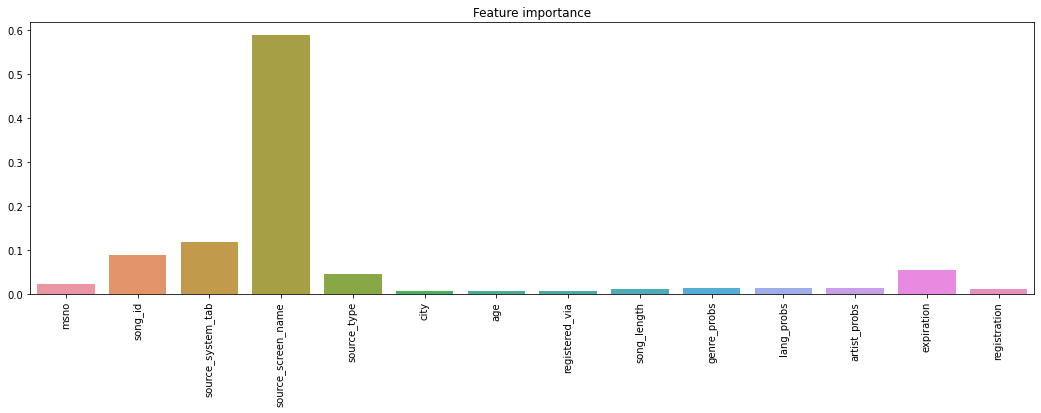

In [65]:
x = train.drop(labels=['target'], axis=1).columns
plt.figure(figsize=(18, 5))
plt.xticks(rotation='vertical')
sns.barplot(x=x, y=feature_imp)
plt.title("Feature importance")
plt.show()

## Задание 2
 
Пользуясь информацией о треках построить неклассические эмбеддинги и попробовать использовать их:

а) показать симилары глазами

б) в качестве рекоммендера вместо GBDT (разницу в метриках) 

в) стек с GBDT (прирост / отсутствие / почему /, SHAP values)

### Смотрим на симилары

In [3]:
from gensim.models import Word2Vec

In [12]:
sentences = defaultdict(list)

In [13]:
for user, song, target in tqdm(zip(train.msno, train.song_id, train.target), total=train.shape[0]):
    sentences[user].append(song)
sent = []
for user, items in sentences.items():
    sent.append(items)

100%|██████████| 7377418/7377418 [00:09<00:00, 771955.43it/s]


In [19]:
config = {
    'window': 10,
    'vector_size': 32,
    'sg': 1,
    'hs': 0,
    'negative': 10,
    'alpha': 0.05,
    'min_alpha': 0.0001,
    'workers': 4,
    'seed': 42
}

In [15]:
model = Word2Vec(**config)
model.build_vocab(sent)

In [61]:
model.train(sent, total_examples=len(sent), epochs=5)

(110342950, 111344890)

In [4]:
# model.save("word2vec.model")
model = Word2Vec.load("word2vec.model")

In [20]:
songs_ = pd.read_csv("data/song_extra_info.csv")

In [29]:
songs = songs.merge(songs_, on='song_id', how='left')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN


In [24]:
song = 'o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU='

In [45]:
sims = model.wv.most_similar(song, topn=10)
print(f'10 songs similar to {songs[songs.song_id == song].name.iloc[0]} ',
      f'by {songs[songs.song_id == song].artist_name.iloc[0]}:')
print()
for song_id, similarity in sims:
    song_info = songs[songs.song_id == song_id]
    print(f'{song_info.name.iloc[0]} by {song_info.artist_name.iloc[0]}, similarity = {round(similarity, 3)}')

10 songs similar to PLAYING WITH FIRE  by BLACKPINK:

BOOMBAYAH by BLACKPINK, similarity = 0.966
Blood Sweat & Tears by BANGTAN BOYS, similarity = 0.952
WHISTLE by BLACKPINK, similarity = 0.941
STAY by BLACKPINK, similarity = 0.94
Russian Roulette by Red Velvet, similarity = 0.93
L.I.E by EXID, similarity = 0.92
Burning Up (FIRE) by BANGTAN BOYS, similarity = 0.919
眼| 鼻| 口 (Eyes| Nose| Lips) by BIGBANG TAEYANG, similarity = 0.919
Very Very Very by I.O.I, similarity = 0.914
11:11 by Taeyeon, similarity = 0.913


Кажется, что на k-pop песню он рекомендует также k-pop песни, включая ту же группу. Значит, в целом, работает неплохо.

### Word2Vec вместо GBDT

In [17]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

In [11]:
current_emb = defaultdict(lambda: np.zeros(32))
embeddings = defaultdict(dict)
cnt = defaultdict(int)

emb = np.zeros((train.shape[0], 32))

msnos = train.msno.unique()

In [15]:
user_embeddings = defaultdict(lambda: np.zeros(32))
cnt = defaultdict(int)

# getting the sum of embeddings for each user
for user, song, target in tqdm(zip(train.msno, train.song_id, train.target), total=train.shape[0]):
    if not target:
        continue
    user_embeddings[user] += model.wv[song]
    cnt[user] += 1

# averaging the sum of embeddings

# for user in user_embeddings.keys():
#     user_embeddings[user] /= cnt[user]

100%|██████████| 7377418/7377418 [00:41<00:00, 177882.08it/s]


In [22]:
scores = []
for user, song, target in tqdm(zip(train.msno, train.song_id, train.target), total=train.shape[0]):
    user_emb = user_embeddings[user].copy()
    try:
        song_emb = model.wv[song]
    except KeyError:
        song_emb = np.zeros(config['vector_size'])
    
    # avoiding the leak
    if target:
        user_emb -= song_emb
        if cnt[user] - 1:
            user_emb /= (cnt[user] - 1)
    score = cosine_similarity(user_emb.reshape(1, -1), song_emb.reshape(1, -1))
    scores.append(score.item())

100%|██████████| 7377418/7377418 [54:59<00:00, 2235.80it/s]  


In [23]:
fpr, tpr, _ = roc_curve(train.target.values, np.array(scores), pos_label=1)
print(f"AUC = {auc(fpr, tpr)}")

AUC = 0.6892585658597024


AUC стал выше на 0.01 пункта

### Стек с GBDT

In [24]:
train = pd.read_csv('train_new.csv', index_col=0)
train['scores'] = scores

/usr/local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [25]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,age,registered_via,song_length,genre_probs,lang_probs,artist_probs,expiration,registration,scores
0,0,0,0,0,0,1,1,0,7,206471.0,-3.410495,-0.633110,-7.515889,2017,2012,0.578362
1,1,1,1,1,1,1,13,24,9,284584.0,-2.541120,-1.696742,-3.254886,2017,2011,0.613395
2,1,2,1,1,1,1,13,24,9,225396.0,-2.541120,-1.696742,-5.739793,2017,2011,0.537892
3,1,3,1,1,1,1,13,24,9,255512.0,-6.432940,-4.130355,-6.432940,2017,2011,0.638238
4,0,4,0,0,0,1,1,0,7,187802.0,-4.950940,-0.633110,-8.614501,2017,2012,0.486537


In [26]:
train.to_csv('train_scores.csv', index=False)
# train = pd.read_csv('train_scores.csv')

In [27]:
config = {'k': 5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 10,
 'eval_metric': 'auc'}

In [28]:
X = train.drop(labels=['target'], axis=1).to_numpy()
y = train['target'].to_numpy()

In [31]:
aucs, feature_imp = train_xgboost(X, y, **config)

100%|██████████| 5/5 [17:17<00:00, 207.46s/it]


In [32]:
print(f'Mean AUC over 5 folds = {np.mean(aucs)}')

Mean AUC over 5 folds = 0.7439694876592136


Результат улучшился почти на 0.06 пункта. Посмотрим на важность фичей:

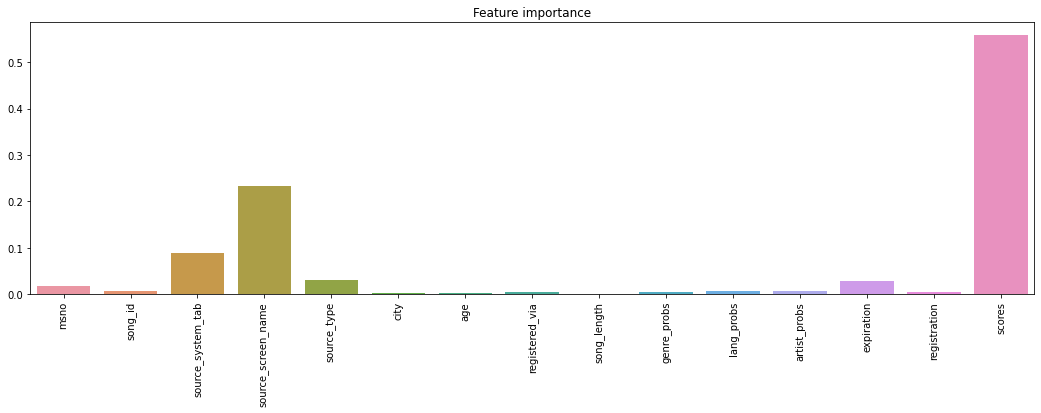

In [35]:
x = train.drop(labels=['target'], axis=1).columns
plt.figure(figsize=(18, 5))
plt.xticks(rotation='vertical')
sns.barplot(x=x, y=feature_imp)
plt.title("Feature importance")
plt.show()

In [36]:
import shap

In [37]:
model = xgb.XGBClassifier(**config,
                          objective="binary:logistic",
                          use_label_encoder=False)
model.fit(X, y)

[19:21:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', k=5, learning_rate=0.1,
              max_delta_step=0, max_depth=10, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', use_label_encoder=False,
              validate_parameters=1, ...)

In [38]:
X_ = train.sample(100, replace=False).drop(labels=['target'], axis=1)

In [39]:
explainer = shap.TreeExplainer(model) #feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


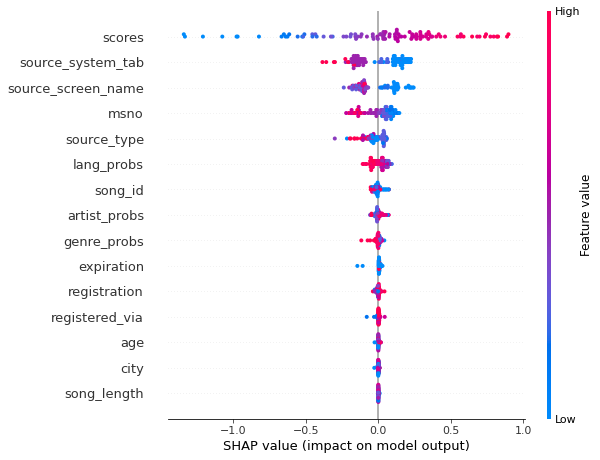

In [40]:
shap.summary_plot(shap_values, X_)

Полученные word2vec скоры больше всего влияют на результат решений модели. То же самое видно и из feature importance графика.